In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm


def kernel(a, b, lenghtscale, std):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return std**2*np.exp(-.5 * (1/lenghtscale) * sqdist)


In [81]:
# From GPY tutorial
n_train = 20
X = np.random.uniform(-3.,3.,(n_train, 1))
Y = (np.sin(X) + np.random.randn(n_train, 1)*0.1).flatten()

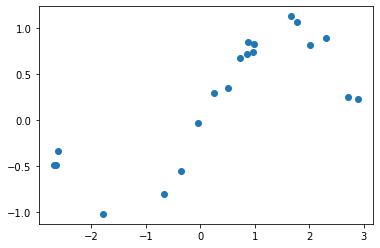

In [82]:
plt.scatter(X[:, 0], Y)

In [83]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    # Variance
    kernel_std = pm.Lognormal("kernel_std", 0, 0.1)
    # Length scale
    kernel_ls = pm.Lognormal("kernel_ls", 0, 1)
    noise_sigma = pm.Lognormal("noise_sigma", 0, 1)
    K = kernel(X, X, kernel_ls, kernel_std) 
    K += np.eye(X.shape[0]) * np.power(noise_sigma, 2)
    
    y = pm.MvNormal("y", mu = 0, cov = K, observed = Y)

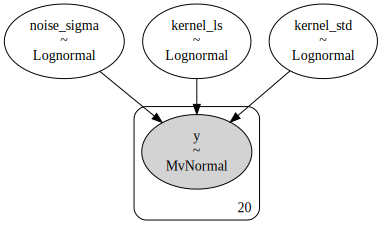

In [91]:
pm.model_to_graphviz(basic_model.model)

In [84]:
map_estimate = pm.find_MAP(model=basic_model)

In [85]:
map_estimate

{'kernel_std_log__': array(-0.0337715),
 'kernel_ls_log__': array(0.55369828),
 'noise_sigma_log__': array(-2.24535811),
 'kernel_std': array(0.96679239),
 'kernel_ls': array(1.73967495),
 'noise_sigma': array(0.10588961)}

In [86]:
with basic_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sigma, kernel_ls, kernel_std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


/usr/local/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa874e9a490>,
      dtype=object)

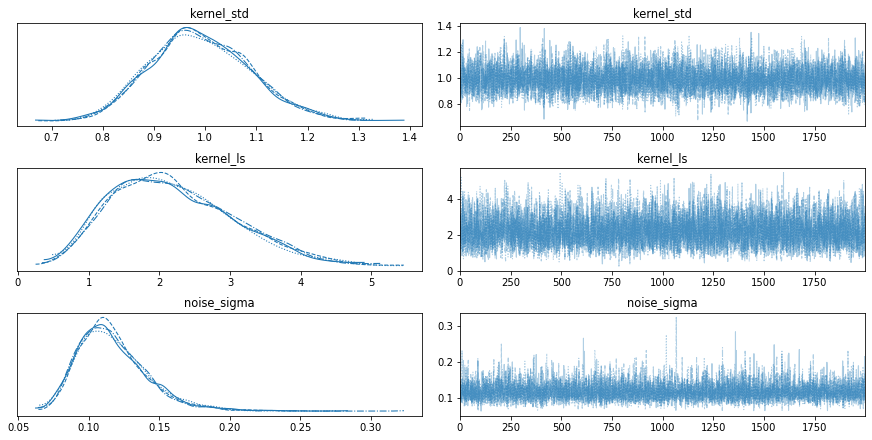

In [87]:
import arviz as az

az.plot_trace(trace)

In [88]:
test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(train_x, train_y, test_x, kernel, kernel_ls, kernel_std, noise):
    N = len(train_x)
    K = kernel(train_x, train_x, kernel_ls, kernel_std)+noise**2*np.eye(len(train_x))
    N_star = len(test_x)
    K_star = kernel(train_x,  test_x, kernel_ls, kernel_std)
    K_star_star = kernel(test_x, test_x, kernel_ls, kernel_std)
    posterior_mu = K_star.T@np.linalg.inv(K)@(train_y)
    posterior_sigma = K_star_star - K_star.T@np.linalg.inv(K)@K_star
    
    
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu, posterior_sigma, size=1)

In [89]:
# Make predictions at new locations.
train_y = Y
n_samples = 500
preds = np.stack([post(train_x, train_y, test_x=test_x, kernel=kernel, kernel_ls=trace['kernel_ls'][b],
                             kernel_std=trace['kernel_std'][b],
                             noise=trace['noise_sigma'][b])
                  for b in range(n_samples)])

preds.shape

(500, 1, 100)

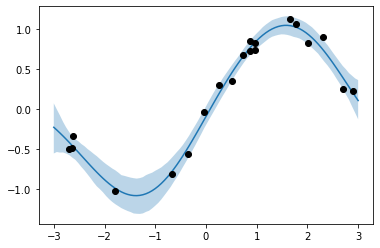

In [90]:
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)



plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))
ci = 95


plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI')